In [30]:
import MDAnalysis
from clustercode import ClusterEnsemble
import matplotlib 
import matplotlib.pyplot as plt

In [31]:
'''
This is a small atomistic trajectory including a single large micelle of aggregation number 100.
The Micelle is composed of SDS which has a HSO4 headgroup and carbon tail groups 
'''
xtc = "files/traj_small.xtc"
tpr = "files/topol_small.tpr"

# First we are going to look at the trajectory with some basic MDAnalysis commands
universe = MDAnalysis.Universe(tpr, xtc)

atom_names = set(universe.atoms.names)
residue_names = set(universe.residues.resnames)
atom_number = universe.atoms.n_atoms
residue_number = universe.residues.n_residues
print('Residue names: {:s}'.format(', '.join(residue_names)))
print('Number of residiue: {:d}'.format(residue_number))
print('Atom names: {:s}'.format(', '.join(atom_names)))
print('Number of atoms: {:d}'.format(atom_number))
print('Length of trajectory: {:d}'.format(universe.trajectory.n_frames))

Residue names: SOL, Cl, Na, SDS
Number of residiue: 6130
Atom names: C9, Na, S, C11, OS4, C4, C8, C2, C12, HW2, C6, C7, Cl, OS2, C1, HW1, C10, OS1, OS3, OW, C3, C5
Number of atoms: 19174
Length of trajectory: 71


In [32]:
'''
We want two molecules to be considered in a cluster when their carbon tails are close enough together. 
Therefore the 'cluster_objects' will be C1 - C12
We initialise the ClusterEnsemble object as follows:
'''
cluster_objects = ['C{:d}'.format(i) for i in range(1,13)]

ClstrEns = ClusterEnsemble(tpr, xtc, cluster_objects)

In [33]:
'''
Run the analysis for each frame within the specified times. cut-off is in Angstroem and describes how close two
objects need to be to considered in the same cluster. This still depends on the measure parameter which is either
centre of geometry (COG), centre of mass (COM) or bead to bead (b2b). 
'''
ClstrEns.cluster_analysis(cut_off=7.5, times=(60e3, 70e3), measure="COM", algorithm="dynamic", work_in="Residue", style="atom")

In [34]:
# This trajectory is larger and describes the inital phase of micellisations
xtc = "files/traj_large.xtc"
tpr = "files/topol_large.tpr"
ClstrEns = ClusterEnsemble(tpr, xtc, cluster_objects)

In [35]:
ClstrEns.cluster_analysis(cut_off=3.5, times=(0, 10000), measure="COM", algorithm="dynamic", work_in="Residue", style="atom")

In [36]:
"""
These function will be added to the object soond as of now they are 
here to use.
"""
def get_cluster_size(cluster_list, frame):
    '''
    This function calculates the size of cluster in a single frame
    '''
    return [len(cluster) for cluster in cluster_list[frame]]

def get_cluster_sizes(cluster_list, first=None, last=None, stride=1):
    '''
    This function calculates the sizes of clusters in multiple frames.
    start and stop are measured in frames.
    '''
    if first is None: first = 0
    if last is None: last = len(cluster_list)
    cluster_sizes = []
    frames = (first, last, stride)
    for frame in range(first, last, stride):
        cluster_sizes.append(get_cluster_size(cluster_list, frame))
    return cluster_sizes

In [37]:
cluster_list = ClstrEns.cluster_list
# Get the size distribution of clusters in the first frame:
frame_0_clusters = ClstrEns.cluster_sizes[50]
def print_clusters(frames, i):
    print('Cluter sizes in {:d}. frame: {:s}'.format(i, ', '.join([str(item) for item in frames])))
print_clusters(frame_0_clusters, 0)

# Get the size distribution of several frames (from 50 to 54 here). 
# The return value of _get_cluster_size and _get_cluster_sizes is actually 
# a list and list of list respectively
frames_clusters = ClstrEns.cluster_sizes[50:55]
for frame, i in zip(frames_clusters, range(50, 55)):
    print_clusters(frame, i)

Cluter sizes in 0. frame: 28, 112, 47, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 50. frame: 28, 112, 47, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 51. frame: 28, 112, 47, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 52. frame: 28, 78, 47, 34, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 53. frame: 28, 11, 67, 47, 34, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 54. frame: 28, 119, 47, 34, 27, 83, 4, 21, 29, 7, 1


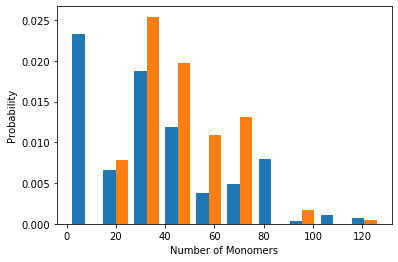

In [38]:
fig, ax = plt.subplots()
ClstrEns.plot_histogram(ax, frames=[(50, 70, 1), (180, 200, 1)], density=True, maxbins=False)

In [39]:
'''
In the cluster_list we have all a list of molecules in each cluter.
We can therefore calculate all kinds of things with it.
'''
ClstrEns.universe.trajectory.rewind()
n_frame = 50
n_cluster = 1
for i, this_cluster in enumerate(ClstrEns.cluster_list):
    print(i)
    if i == n_frame:
        special_cluster = this_cluster[n_cluster]
        COM = special_cluster.center_of_mass()
        print('Centre of mass: {:.2f}, {:.2f}, {:.2f}'.format(*COM))
        


# A cluster is a Residuegroup, we can use all the methods defined for
# Residuegroups
print('Type of special_cluster: {:s}'.format(type(special_cluster).__name__))

COM = special_cluster.center_of_mass()
print('Centre of mass: {:.2f}, {:.2f}, {:.2f}'.format(*COM))
print('Centre of geomety: {:.2f}, {:.2f}, {:.2f}'.format(*special_cluster.center_of_geometry()))
print('Radius of gyration: {:.3f}'.format(special_cluster.radius_of_gyration()))
print('Ids of residues(molecules) in this cluster: ')
print(special_cluster.resids)
print('Type of residues(molecules) in this cluster: ')
print(special_cluster.resnames)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Centre of mass: 45.18, 30.05, 45.54
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Type of special_cluster: ResidueGroup
Centre of mass: 40.40, 32.66, 40.25
Centre of geomety: 40.12, 32.37, 40.24
Radius of gyration: 37.359
Ids of residues(molecules) in this cluster: 
[  1   2   3   4   6   7  12  17  19  20  30  37  39  43  46  55  56  61
  62  70  89

In [48]:
'''
In the cluster_list we have all a list of molecules in each cluter.
We can therefore calculate all kinds of things with it.
'''

ClstrEns.universe.trajectory.rewind()
n_frame = 50
n_cluster = 1
for i, this_cluster in enumerate(ClstrEns.cluster_list):
    if i%10. < 1.0e-6: print(i)
    if i == n_frame:
        special_cluster = this_cluster[n_cluster]
        COM = special_cluster.center_of_mass()
        print('Centre of mass: {:.2f}, {:.2f}, {:.2f}'.format(*COM))
        ClstrEns.unwrap_cluster(special_cluster, verbosity=1)
        COM = special_cluster.center_of_mass()
        print('Centre of mass: {:.2f}, {:.2f}, {:.2f}'.format(*COM))
    


# A cluster is a Residuegroup, we can use all the methods defined for
# Residuegroups
print('Type of special_cluster: {:s}'.format(type(special_cluster).__name__))

COM = special_cluster.center_of_mass()
print('Centre of mass: {:.2f}, {:.2f}, {:.2f}'.format(*COM))
print('Centre of geomety: {:.2f}, {:.2f}, {:.2f}'.format(*special_cluster.center_of_geometry()))
print('Radius of gyration: {:.3f}'.format(special_cluster.radius_of_gyration()))
print('Ids of residues(molecules) in this cluster: ')
print(special_cluster.resids)
print('Type of residues(molecules) in this cluster: ')
print(special_cluster.resnames)

0
10
20
30
40
50
Centre of mass: 45.18, 30.05, 45.54
Shifting molecule 26 by 0.00, -95.25, 0.00
Shifting molecule 111 by 0.00, -95.25, 0.00
Shifting molecule 60 by 0.00, 0.00, -95.25
Shifting molecule 103 by 0.00, 0.00, -95.25
Shifting molecule 80 by 0.00, 0.00, -95.25
Shifting molecule 89 by 0.00, 0.00, -95.25
Shifting molecule 79 by 0.00, 0.00, -95.25
Shifting molecule 107 by 0.00, 0.00, -95.25
Shifting molecule 33 by 0.00, 0.00, -95.25
Shifting molecule 100 by 0.00, 0.00, -95.25
Shifting molecule 13 by 0.00, 0.00, -95.25
Shifting molecule 86 by 0.00, 0.00, -95.25
Shifting molecule 0 by 0.00, 0.00, -95.25
Shifting molecule 44 by -95.25, 0.00, 0.00
Shifting molecule 39 by -95.25, 0.00, 0.00
Shifting molecule 90 by -95.25, 0.00, 0.00
Shifting molecule 84 by -95.25, 0.00, 0.00
Shifting molecule 38 by -95.25, 0.00, 0.00
Shifting molecule 15 by -95.25, 0.00, 0.00
Shifting molecule 47 by -95.25, 0.00, 0.00
Shifting molecule 51 by -95.25, 0.00, 0.00
Shifting molecule 82 by -95.25, 0.00, 0.0